In [5]:
%matplotlib inline

from __future__ import absolute_import, print_function, unicode_literals, division
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import random as rand
import copy

In [6]:
DATA_PATH = '~/data'
mnist = fetch_mldata('MNIST original', data_home=DATA_PATH)
print(mnist.data.shape)

(70000, 784)


In [7]:
data_array = mnist.data
print(data_array[0])
print(data_array.shape)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 163 252 252 252 253 252 252  96 189 253 167   

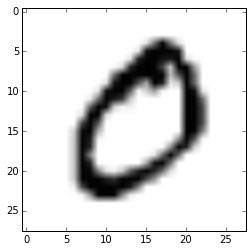

In [8]:
plt.imshow(data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

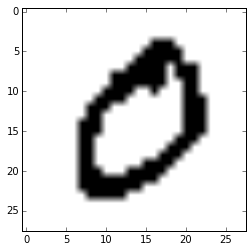

In [9]:
#Convert image to binary matrix
for img in data_array:
    img[img < 100] = 0
    img[img > 0] = 1

plt.imshow(data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

In [70]:
class RBM(object):
    """
    Implementation of Restricted Boltzmann Machine for binary prediction
    
    Inputs:
    Data
    Number of hidden and visible states
    Learning rate, default set to 0.1
    
    Outputs:
    Weight matrix
    Epoch number and error
    """

    def __init__(self, data, num_visible, num_hidden, learning_rate=0.1):
        
        self.data = data
        self.num_data = data.shape[0]
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.learning_rate = learning_rate

        # weight matrix first row and first column represent the bias
        self.weights = np.random.rand(self.num_visible, self.num_hidden) 
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)
    
    def _sigmoid(self,x):
        """
        Logistic Sigmoid Activation Function
        """
        return 1.0/(1.0+np.exp(-x))
    
    def _sample_h_given_v(self, v):
        """
        Predicts hidden layer given visible layer
        """
        hid = self._sigmoid(np.dot(v, self.weights))
        hidden_states = hid > np.random.rand(self.num_hidden + 1)
        return hidden_states
    
    def _sample_v_given_h(self, h):
        """
        Predicts visible layer given hidden layer
        """
        vis = self._sigmoid(np.dot(h, self.weights.T))
        visible_states = vis > np.random.rand(self.num_visible + 1)

        return visible_states
    
    def _propagate_up(self, vis):
        """
        Propagates visible layer activation to hidden layer
        """
        vis_activation = self._sigmoid(np.dot(vis, self.weights))
        sample = vis_activation > np.random.rand(self.num_data, self.num_hidden + 1)
        return sample

    def _propagate_down(self, hid):
        """
        Propagates hidden layer activation to visible layer
        """
        hidden_activation = self._sigmoid(np.dot(hid, self.weights.T))
        return hidden_activation

    
    def CDk(self, max_epochs=1000):
        """
        Trains the RBM
        """
        self.data = np.insert(self.data, 0, 1, axis=1)
        
        for epoch in xrange(0, max_epochs):
            
            # CDk positive phase
            up_data = self._propagate_up(self.data)
            up_associations = np.dot(self.data.T, up_data)
            
            # CDk negative phase
            down_vis_probs = self._propagate_down(up_data)
            #remove the bias layer
            down_vis_probs[:,0] = 1 
            down_associations = self._sigmoid(np.dot(down_vis_probs, self.weights))            
            down_associations = np.dot(down_vis_probs.T, down_associations)
            
            self.weights += self.learning_rate * \
                ((up_associations - down_associations)/self.num_data)
                
            error = np.sum((self.data - down_vis_probs) ** 2)
            print("Epoch: ", epoch, ", Error: ", error)
            if epoch == 100:
                return down_vis_probs
    
    def Gibbs_alternating(self, num_gen_samples):
        """
        """
        
        samples = np.ones((num_gen_samples, self.num_vis + 1))
        samples[0,1:] = np.random.rand(self.num_vis)
        
        for i in xrange(0, self.num_data-1):
            
            v = samples[i-1,:]
            h = _sample_h_given_v(v)
            h[0] = 1

            v = _sample_v_given_h(h)
            samples[i,:] = v      
        
        return samples[:,1:]
            

In [71]:
r = RBM(data_array, 784, 3, .1)
sample = r.CDk(max_epochs=101)
print(r.weights)
#user = data[11] #np.array([[1, 0, 0, 0, 1, 0]])
#print(r._sample_h_given_v(user))

Epoch:  0 , Error:  30695865.955
Epoch:  1 , Error:  28047699.1269
Epoch:  2 , Error:  25392030.0675
Epoch:  3 , Error:  22802621.2881


KeyboardInterrupt: 

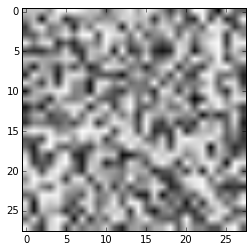

In [68]:
plt.imshow(sample[11][1:].reshape(28,28), cmap = 'Greys')
plt.show()

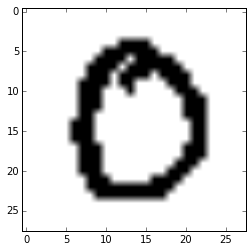

In [69]:
plt.imshow(data_array[11].reshape(28,28), cmap = 'Greys')
plt.show()